
## Taller de Procesamiento de Señales - TP4 Análisis de Discriminante y Vecinos más cercanos
### Alumno: Julián Stejman

--- 


Iris es un género de plantas rizomatosas de la familia Iridaceae. Dentro de las plantas de Iris existen muchas especies distintas, entre ellas *setosa*, *versicolor* y *virgínica*. Se desea desarrollar un clasificador de dichas plantas a partir del tamaño de su sépalo.

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
iris_data, iris_targets = load_iris(return_X_y=True, as_frame=True)
iris_data = iris_data[['sepal length (cm)', 'sepal width (cm)']]
iris_targets = iris_targets.astype('category')


0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: target, Length: 150, dtype: category
Categories (3, int64): [0, 1, 2]

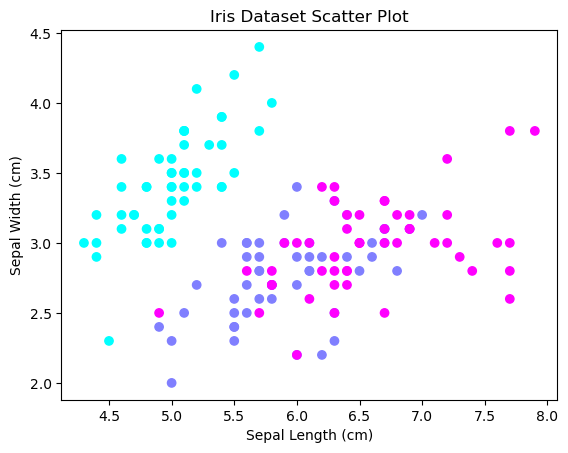

In [25]:

ax, fig = plt.subplots()
fig.scatter(iris_data['sepal length (cm)'], iris_data['sepal width (cm)'], c=iris_targets, cmap="cool")
fig.set_xlabel('Sepal Length (cm)')
fig.set_ylabel('Sepal Width (cm)')
fig.set_title('Iris Dataset Scatter Plot')
plt.show()


In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)  # only difference


,sepal length (cm),sepal width (cm)
0,0.002220,0.009402
1,0.001817,0.005703
2,0.001488,0.006965
3,0.001346,0.006302
4,0.002008,0.010391
...,...,...
145,0.010994,0.005703
146,0.007369,0.003459
147,0.009001,0.005703
148,0.006668,0.008507


In [58]:
import numpy as np
class LDA_classifier: 
    def __init__(self):
        self.means = None
        self.cov = None
        self.priors = None
        self.classes = None
    def fit(self, X, y):
        self.classes = set(y)
        num_classes = len(self.classes)
        num_samples = X.shape[0]

        # valores de c_k
        self.priors = [np.sum(y == c) / num_samples for c in self.classes] 
        # medias
        self.means = 1/num_classes * np.sum(X, axis=0)
        # valores de sigma_k
        _sigmak = 1/(num_classes - 1) * (X-self.means)@(X-self.means).T
        # covariancia
        self.cov = 1/(num_samples-num_classes) * np.sum((num_classes -1)*_sigmak, axis=0)
    def _softmax(self, X):
        exp = np.exp(X)
        return exp / np.sum(exp, axis=1, keepdims=True)    
    def predict_proba(self, X):
        lin_discr = self.means.T @ np.linalg.inv(self.cov) @ X 
        - 0.5 * self.means.T @ np.linalg.inv(self.cov) @ self.means + np.log(self.priors)
        probas = self._softmax(lin_discr)
        return probas

    def predict(self, X):
        probas = self.predict_proba(X)
        return self.classes[np.argmax(probas)]

In [59]:
lda = LDA_classifier()
lda.fit(iris_data, iris_targets)
lda.means

sepal length (cm)    292.166667
sepal width (cm)     152.866667
dtype: float64